# Analysis of heterogeneity in the relationship between BMI and risk biomarkers

*This is a guideline to be followed by analysts in SOPHIA who are participating in Working Group 1 - Cross-sectional clustering in the general population.*

*Not everyone has to follow all the steps, as we require different things from every cohort. We have therefore added who should cover each section.*

*The cohorts have been divided into:*

- **Discovery:**
    - UK Biobank
    
- **Validation:**
    - Maastricht
    - Rotterdam
    - GHS
    
- **Mental health:**
    - Girona
    
- **Intervention:**
    - SCALE
    - ABOS

## Background - All

Generally the relationship between BMI and multiple diseases is assumed to follow a continuum. However, it has also been observed that there are groups of people in which this relationship is disproportionally stronger or weaker for any given BMI. Our objective is to test the hypothesis that clustering-based approaches can be used to better capture these subgroups.

## Pipeline overview - All

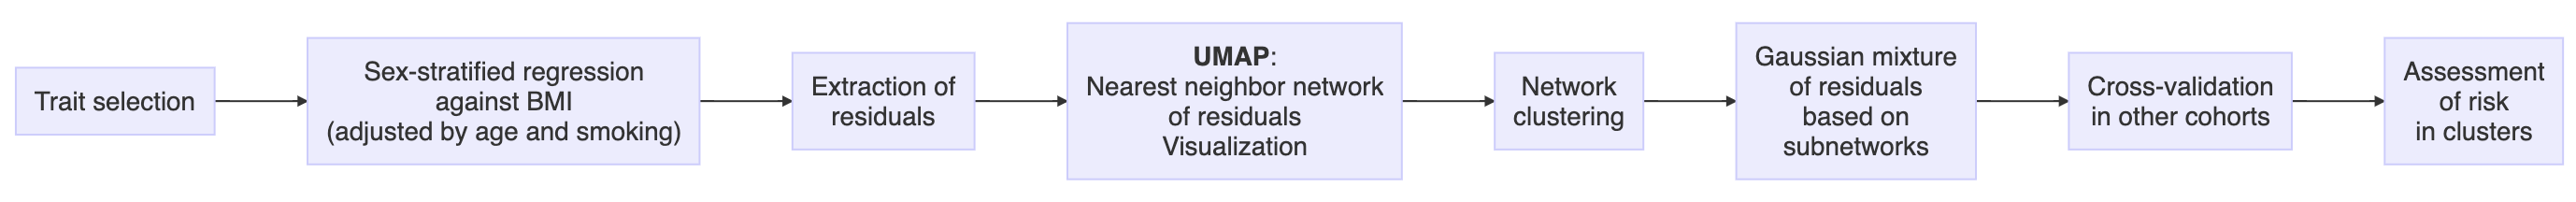

## Trait selection - All

We have selected 10 traits, based on biological systems that are commonly affected by obesity:

- Blood pressure: SBP and DBP.
- Lipids: HDL, LDL, TG.
- Fat distribution: WHR.
- Glycemia: Fasting glucose.
- Liver metabolism: ALT.
- Kidney function: Creatinine.
- Inflammation: CRP.

The covariates that will be needed are:

- Sex.
- Age.
- Current smoking status, coded as 1 if current smoker, 0 otherwise.


## Initial input - All

The initial input table should look like the following. If possible we would like the names to match so that the functions work properly.

In [9]:
recoded_dat <- crude_dat %>%
    ## Only European descent individuals
    filter(caucasian == 1) %>%
    select(-caucasian) %>%
    transmute(eid, age, 
              sex = ifelse(sex == 0, "Female", "Male"),
              ## Anthropometric
              bmi, 
              whr = waist_circumference / hip_circumference,
              ## Blood pressure
              sbp = rowMeans(cbind(sbp_01, sbp_02), na.rm = TRUE),
              dbp = rowMeans(cbind(dbp_01, dbp_02), na.rm = TRUE),
              ## Liver function
              alt,
              ## Kidney function
              scr = creatinine,
              ## Inflammatory markers
              crp,
              ## Lipid fractions
              hdl, tg, ldl,
              ## Glycemia - At least fasting time of 4 hours
              fg = ifelse(fasting_time >= 4, glucose, NaN),
              ## Current smoking status
              smoking = case_when(current_smoker %in% c(1,2) ~ 1,
                                  current_smoker == 0 ~ 0,
                                  TRUE ~ NaN)) %>%
    ## Removing outliers for all variables (except age)
    mutate(across(-c(eid, sex, age, smoking), remove_outliers)) %>%
    ## Only complete cases
    drop_na
head(recoded_dat)
nrow(recoded_dat)

eid,age,sex,bmi,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg,smoking
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000039,44,Male,36.9,0.9911504,124.5,64.5,34.97,93.0,3.60,1.158,2.800,3.956,5.427,0
1000071,67,Male,39.5,0.8857143,179.5,103.0,46.74,68.7,9.41,1.372,1.127,2.311,7.079,0
1000088,60,Male,24.3,0.8761905,152.0,89.0,13.14,80.6,1.20,0.983,1.590,4.200,5.401,0
1000096,41,Male,26.6,0.9587629,143.0,90.0,30.32,80.1,6.13,1.041,2.713,4.029,4.239,0
1000109,62,Male,33.9,1.0818182,156.5,104.5,16.26,89.3,14.42,0.890,2.437,3.525,6.100,0
1000117,47,Female,23.8,0.7254902,147.5,84.0,14.07,61.0,0.24,1.972,0.591,2.252,4.395,0


[1] 142846

## Functions to generate result tables - All

All steps are intended to be followed in the R environment. To facilitate the analyses we have put together a list of functions that can then be used to run every step of this guideline. They are located in the accompanying file `cross_sectional_FX.R`. You can load this list of functions like this:

In [ ]:
source("cross_sectional_FX.R")

The requirements for the R environment are the following:

## Cluster analysis and validation - Validation cohorts

Thanks to all analysts participating, we have already successfully run our pipeline in all 4 validation cohorts.
However, to put the paper together we will need some tables that were generated while running the pipeline. If these are not available, some of the functions in our list can be used to easily generate them, assuming the initial input table is in the format we specified above.

## Sex stratified residualization for BMI

We then run a linear model for every trait against BMI, with age and smoking as covariates. We do this separately for each sex. Something like:

```
for(variable in variables){
    model <- lm(variable ~ age + smoking + bmi, data = sex_specific_data)
    model
}
```

Then we extract these residuals for every trait and the center and scale them, so they are in standard deviation units. 

```
for(model in models){
    resid_data <- resid(model)
    std_resid_data <- scale(resid_data)
    return(std_resid_data)
}
```

We have in the end a dataset that looks like this, here called `sex_stratified_data`:

In [3]:
strat_dat <- map(
    setNames(c("Female", "Male"), c("Female", "Male")),
    ~read_tsv(paste0("../data/transf_dat_", .x, ".tsv"), show_col_types = FALSE)
)
map(strat_dat, head)
map(strat_dat, nrow)

eid,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000117,-0.9330494,1.1958033,0.5144650,-0.3546433,-0.16882313,-0.407089837,0.8492311,-0.7802373,-1.3758075,-0.69085703
1000132,-0.1816070,0.4062332,1.5712102,-0.4061697,-0.43500798,-0.003143314,-0.2618377,0.4554830,0.2500211,0.52876190
1000176,-0.1782880,-0.9749966,0.5359662,1.0547823,0.09854245,-0.605120984,0.7026216,-0.3642810,0.6391341,-1.71339136
1000223,-0.5743141,1.1942282,1.3737863,-1.4726312,0.24248219,-0.299527472,-0.6663167,1.7319302,-0.3157011,1.45001748
1000282,-0.3725576,0.4145254,0.9409365,-0.9231915,-1.60456430,-0.581223948,1.5760528,-0.7340595,0.1348192,0.64670127
1000367,-1.1466227,-0.6784428,-0.4016598,-0.5740235,-0.40145926,0.175763232,1.6110793,-0.6295654,-0.2556987,-0.04672528
eid,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000039,-0.1853279,-0.9005941,-2.6310771,-0.30783902,0.83583978,0.1813894,0.33123356,0.24995749,0.3080423,0.5143975


$Female
[1] 76064

$Male
[1] 66782

## UMAP

We use this residuals to run UMAP. Apart from the projection in 2 dimensions, we will use the `fgraph`, which is a sparse matrix of size individuals x individuals, representing the network which underlies the projection. This matrix is filled with 1 if there is a connection between 2 individuals in the network, and 0 otherwise.

In [ ]:
umap_res <- sex_stratified_data %>%
    map(
        ~{
            dat <- select(.x, -eid)
            n_total <- nrow(dat)
            nn <- round(10 + 15 * (log10(n_total) - 4))
            umap(
                # Data and number of dimensions to return
                dat, n_components = 2, 
                # Parameters to build the nearest-neighbor graph
                n_neighbors = nn, nn_method = "annoy", n_trees = 100, 
                n_sgd_threads = "auto", 
                # Parameters for the embedding
                init = "pca", n_epochs = 500, approx_pow = TRUE,
                binary_edge_weights = TRUE, dens_scale = 1, 
                # Additional elements to return
                ret_extra = "fgraph",
                verbose = FALSE
            )
        }
    )

The 2D-projection is found in the `embedding` object:

In [6]:
umap_embed <- umap_res %>%
    map(pluck, "embedding") %>%
    map2(strat_dat, ~data.frame(eid = .y$eid, .x))
map(umap_embed, head)

,eid,X1,X2
,<dbl>,<dbl>,<dbl>
1,1000117,-0.2101980,-0.7729634
2,1000132,0.3824591,-0.4985204
3,1000176,-0.2179300,-0.2772867
4,1000223,0.6313092,-0.4690245
5,1000282,-0.2458237,-0.7725259
6,1000367,-0.7014181,-0.4288971
,eid,X1,X2
,<dbl>,<dbl>,<dbl>
1,1000039,0.6547522,0.02940817


And the `fgraph` object should look like this:

In [37]:
umap_res %>%
    map("fgraph") %>%
    map(~.x[1:5, 1:5])

$Female
5 x 5 sparse Matrix of class "dgCMatrix"
              
[1,] . . . . .
[2,] . . . . .
[3,] . . . . .
[4,] . . . . .
[5,] . . . . .

$Male
5 x 5 sparse Matrix of class "dgCMatrix"
              
[1,] . . . . .
[2,] . . . . .
[3,] . . . . .
[4,] . . . . .
[5,] . . . . .


## Network clustering

We will use the clustering algorithms available in the `igraph` package:

- Convert matrix into `igraph` object:

In [9]:
umap_graphs <- umap_res %>%
    map(~igraph::graph_from_adjacency_matrix(.x$fgraph, mode = "undirected")) %>%
    map2(strat_dat, ~{ igraph::V(.x)$name <- .y$eid; .x })

In [10]:
umap_graphs %>%
    map(~.x)

$Female
IGRAPH 869ee64 UN-- 76064 1242390 -- 
+ attr: name (v/n)
+ edges from 869ee64 (vertex names):
 [1] 1000117--1341427 1000117--1437388 1000117--1634286 1000117--1767696
 [5] 1000117--1817164 1000117--1866671 1000117--1891180 1000117--1912856
 [9] 1000117--1989881 1000117--2020601 1000117--2236225 1000117--2337740
[13] 1000117--2352567 1000117--2637042 1000117--2646044 1000117--2665443
[17] 1000117--2757381 1000117--3143341 1000117--3181538 1000117--3228159
[21] 1000117--3251539 1000117--3331569 1000117--3970003 1000117--4204119
[25] 1000117--4217689 1000117--4221417 1000117--4289753 1000117--4389510
[29] 1000117--4517368 1000117--4556294 1000117--4650884 1000117--4801048
+ ... omitted several edges

$Male
IGRAPH 2825c49 UN-- 66782 1035525 -- 
+ attr: name (v/n)
+ edges from 2825c49 (vertex names):
 [1] 1000039--1394553 1000039--1435461 1000039--1498747 1000039--2023998
 [5] 1000039--2054726 1000039--2354837 1000039--2391043 1000039--2407154
 [9] 1000039--2446675 1000039--2659747 

Clustering using the Leiden algorithm, with initial seeds using the leading eigenvector algorithm:

In [11]:
graph_clusters <- umap_graphs %>%
    map(~igraph::cluster_leading_eigen(.x)) %>%
    map2(umap_graphs, 
         ~igraph::cluster_leiden(.y, objective_function = "modularity", initial_membership = .x$membership, n_iterations = 500))

Extracting memberships:

In [15]:
memb_dat <- graph_clusters %>%
    map(igraph::membership) %>%
    map(~data.frame(eid = as.numeric(names(.x)), cluster = as.numeric(.x)))
map(memb_dat, head)

,eid,cluster
,<dbl>,<dbl>
1,1000117,1
2,1000132,2
3,1000176,4
4,1000223,5
5,1000282,1
6,1000367,4
,eid,cluster
,<dbl>,<dbl>
1,1000039,1


Extracting the corresponding subgraphs of each cluster:

In [17]:
cluster_subgraphs <- memb_dat %>%
    map2(
        umap_graphs,
        ~{
            .x %>%
                split(f = .$cluster) %>%
                map(
                    function(clus){
                        igraph::induced_subgraph(.y, as.character(clus$eid))
                    }
                )
        }
    )

The we calculate eigen centrality, which returns a value between 0 and 1. The higher the value, the higher the importance of an individual in the subgraph:

In [18]:
ev_dat <- cluster_subgraphs %>%
    map(
        ~{
            map_df(
                .x, 
                function(clus){ 
                    evcent <- igraph::eigen_centrality(clus, directed = FALSE)$vector
                    data.frame(
                        eid = as.numeric(names(evcent)),
                        value = as.numeric(evcent)
                    )
                },
                .id = "cluster"
            ) %>%
                mutate(cluster = as.numeric(cluster))
        }
    )
map(ev_dat, head)

,cluster,eid,value
,<dbl>,<dbl>,<dbl>
1,1,1000117,0.08882629
2,1,1000282,0.19425157
3,1,1001442,0.31167594
4,1,1002170,0.04066088
5,1,1002878,0.03855851
6,1,1004797,0.20109182
,cluster,eid,value
,<dbl>,<dbl>,<dbl>
1,1,1000039,0.03123327


## Fit of Gaussian mixture using subnetworks (clusters) found

We assume here that every cluster - or subnetwork - can be described as a Gaussian distribution with its own center and covariance matrix, where individuals are weighted by their corresponding centrality values. To find these centers and covariance matrices we run the following:

In [ ]:
cluster_pars <- ev_dat %>%
    map2(sex_stratified_dat, ## The data we used initially to run UMAP
         inner_join) %>% ## This step is to map individuals back to the data used to run UMAP
    map(
        ~{
            .x %>%
                split(f = .$cluster) %>% ## For every cluster, we calculate a Gaussian distribution (center and covariance matrix), weighted by centrality values
                map(
                    function(clusdat){
                        cov.wt(select(clusdat, whr, sbp, dbp, alt, scr, crp, hdl, tg, ldl, fg), wt = clusdat$value, cor = TRUE)
                    }
                )
        }
    )

To see what we have here, I show the centers and covariance matrices we obtain in each cluster in UK Biobank:

- Centers:

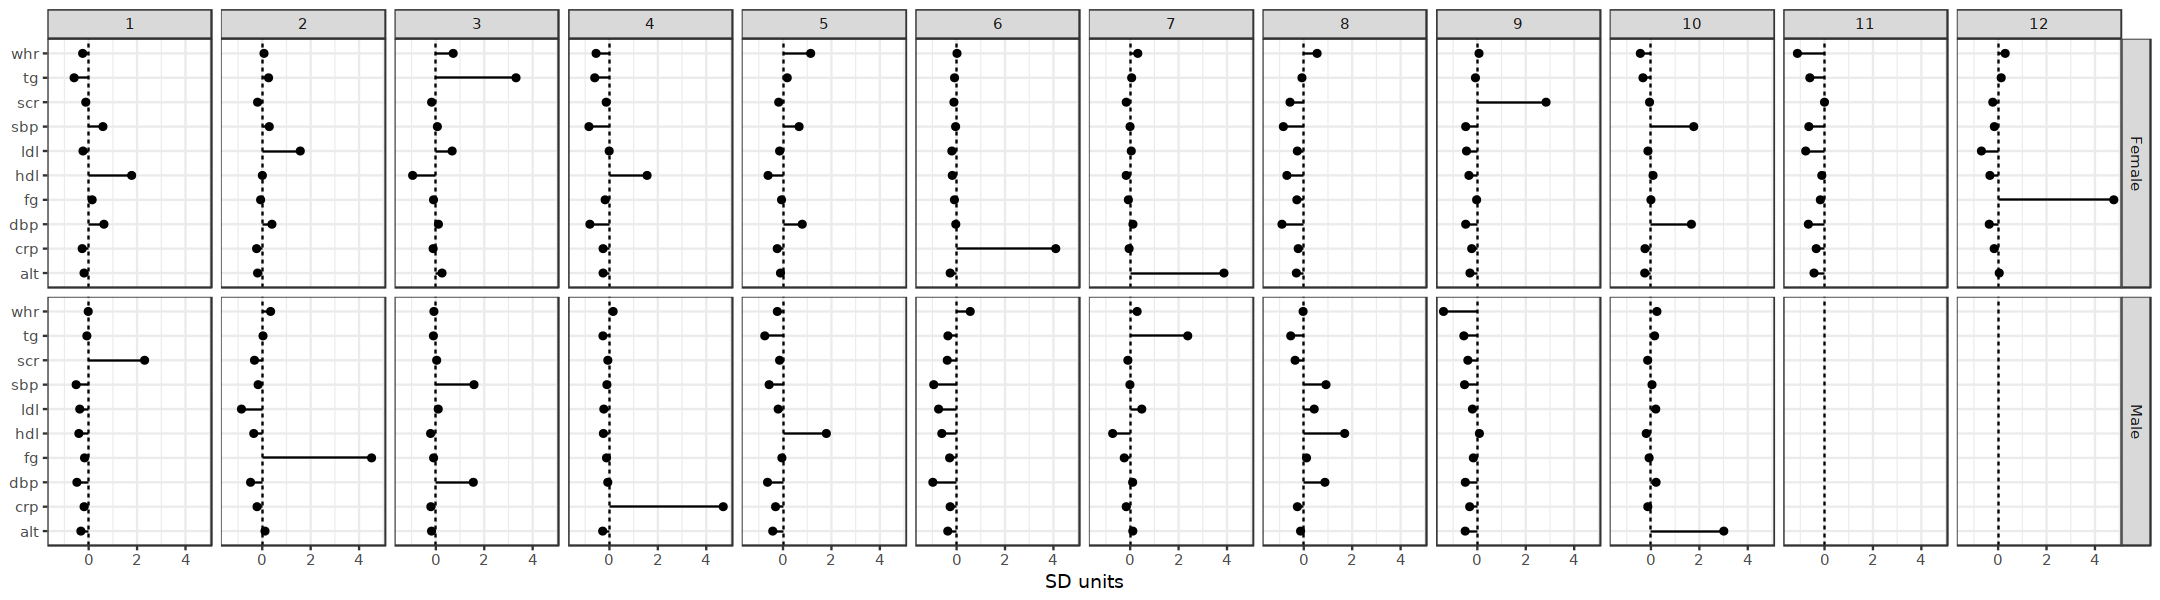

In [7]:
options(repr.plot.width = 18, repr.plot.height = 5)
cluster_pars %>%
    map(map, pluck, "center") %>%
    map(map, t) %>%
    map(map_dfr, data.frame, .id = "cluster") %>%
    bind_rows(.id = "sex") %>%
    mutate(cluster = as.numeric(cluster)) %>%
    pivot_longer(-c(sex, cluster)) %>%
    ggplot(aes(value, name)) +
    geom_vline(xintercept = 0, lty = "dashed") +
    geom_segment(aes(xend = 0, yend = name)) +
    geom_point() +
    facet_grid(sex ~ cluster) +
    theme_bw() +
    labs(x = "SD units", y = NULL)

- Covariance matrices:

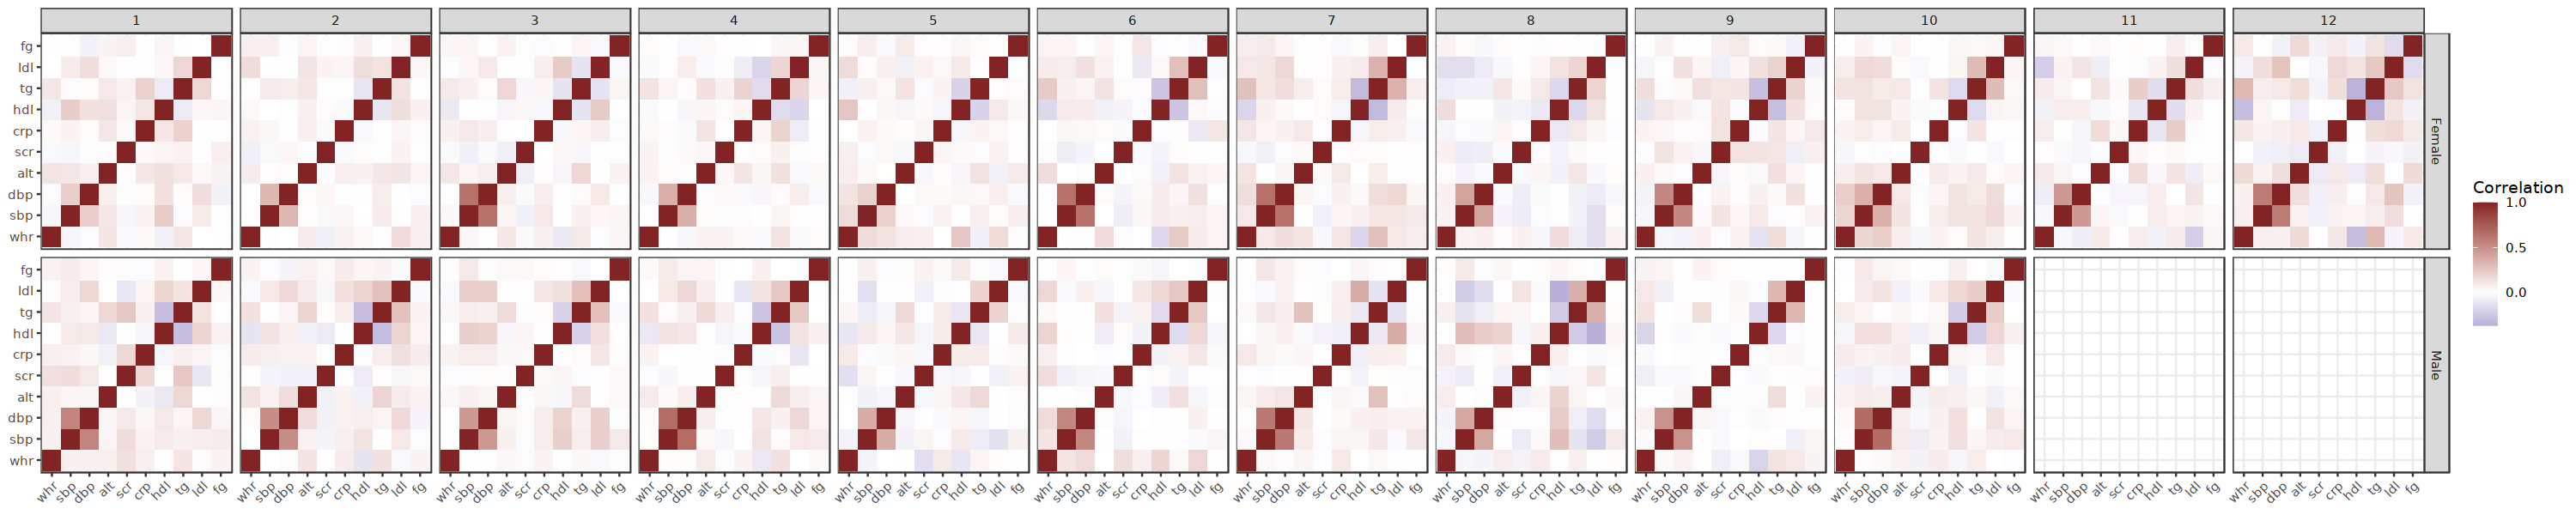

In [8]:
options(repr.plot.width = 25, repr.plot.height = 5)
cluster_pars %>%
    map(map, pluck, "cor") %>%
    map(map_dfr, reshape2::melt, .id = "cluster") %>%
    bind_rows(.id = "sex") %>%
    mutate(cluster = as.numeric(cluster)) %>%
    ggplot(aes(Var1, Var2)) +
    geom_tile(aes(fill = value)) +
    scale_fill_gradient2(low = scales::muted("blue"), high = scales::muted("red")) +
    facet_grid(sex ~ cluster, scales = "free") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x = NULL, y = NULL, fill = "Correlation")

Having these centers and covariance matrices allows us to calculate for every individual the probabilities to belong to each of these clusters using the Gaussian mixture framework. The centers and covariance matrices are fixed, so we would need to find the weights corresponding to every distribution. 

## Important step before fitting the Gaussian Mixture model!

Since we know that BMI is generally a good predictor for all variables, we should also include in the model a cluster where the standardised residual values should be normally distributed around 0. We can add this to our Gaussian mixture model.

- The subdistribution corresponding to BMI explaining most of the variation:

In [9]:
center_subdis <- list(
    cov = diag(rep(1, ncol(sex_stratified_dat$Female) - 1)),
    center = rep(0, ncol(sex_stratified_dat$Female) - 1)
)
center_subdis

1,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0
0,0,0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,1


- Adding this to the list of Gaussian distributions found:

In [10]:
cluster_pars0 <- cluster_pars %>%
    map(~{.x$`0` <- center_subdis; .x})
map(cluster_pars0, names)

$Female
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "0" 

$Male
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "0"

We can then use this list of Gaussian distributions, each with its corresponding center and covariance matrix, to calculate both the weights of each distribution and also the probability of each individual to belong to each distribution:

In [ ]:
gmm_res <- cluster_pars0 %>%
    map2(
        sex_stratified_dat,
        ~{
            d <- select(.y, -eid)
            mus <- map(.x, function(clus){ clus$center })
            covmats <- map(.x, function(clus){ clus$cov })
            pdfs <- map2(mus, covmats, function(mu, covmat){ mvtnorm::dmvnorm(d, mu, covmat) })
            k <- length(mus)
            ws <- rep(1 / k, k)
            L <- map2(pdfs, ws, function(pd, w){ pd * w })
            Lmat <- do.call(cbind, L)
            probs <- Lmat / rowSums(Lmat)
            Lclus <- colSums(probs)
            loglik <- sum(log(rowSums(Lmat)))
            Delta <- 1
            iter <- 1
            itermax <- 100
            while(Delta > 1e-10 && iter <= itermax){
                ws <- Lclus / sum(Lclus)
                L <- map2(pdfs, ws, function(pd, w){ pd * w })
                Lmat <- do.call(cbind, L)
                probs <- Lmat / rowSums(Lmat)
                Lclus <- colSums(probs)
                loglik_current <- sum(log(rowSums(Lmat)))
                Delta <- loglik_current - loglik
                loglik <- loglik_current
                iter <- iter + 1
            }
            print(paste("Convergence reached in", iter, "iterations"))
            list(probs = probs, weights = ws)
        }
    )

With this we have the weights, a number from 0 to 1 which reflects the likelihood of each cluster:

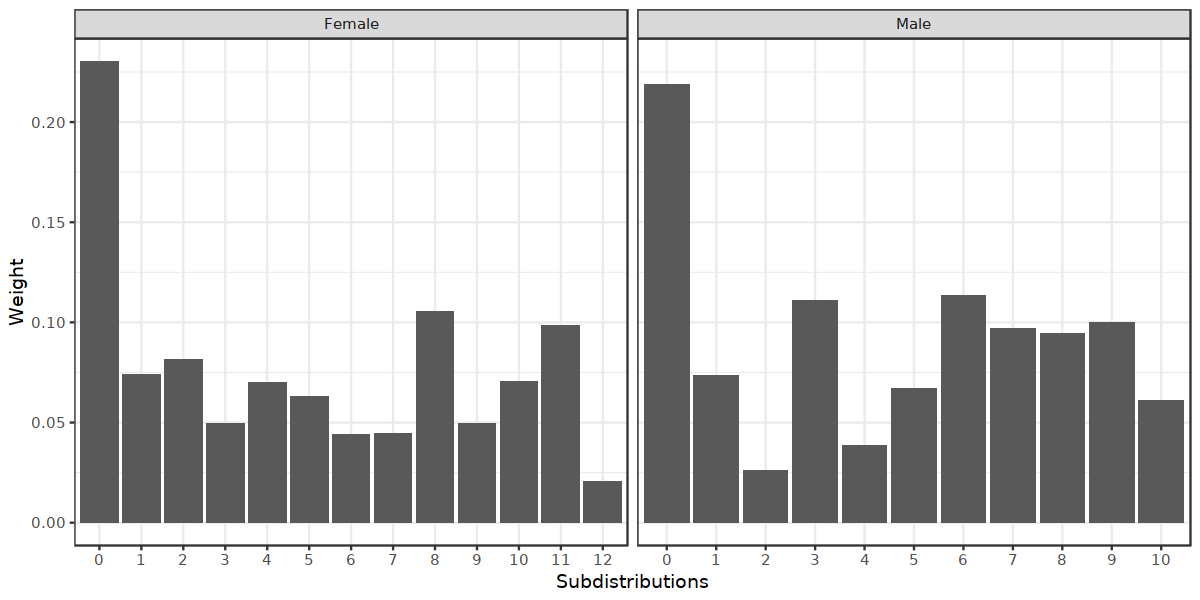

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5)
gmm_res %>%
    map(pluck, "weights") %>%
    map(data.frame) %>%
    map(setNames, "Weight") %>%
    map_dfr(tibble::rownames_to_column, var = "cluster", .id = "sex") %>%
    mutate(clusterord = as.numeric(cluster)) %>%
    ggplot(aes(reorder(cluster, clusterord), Weight)) +
    geom_col() +
    facet_wrap(~sex, nrow = 1, scales = "free_x") +
    theme_bw() +
    labs(x = "Subdistributions")

Generally you should see in your data that the highest prior is given to the 'concordant' cluster.

We also obtain a matrix of probabilities, which tells us for every individual, what is the probability to belong to each cluster, including the cluster where BMI is a perfectly good predictor:

In [10]:
cluster_probs <- gmm_res %>%
    map2(sex_stratified_dat, ~data.frame(eid = .y$eid, .x$probs)) %>%
    map(rename_with, gsub, pattern = "X", replacement = "cluster_")
map(cluster_probs, head)

$Female
# A tibble: 6 x 14
      eid  cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6 cluster_7
    <dbl>      <dbl>     <dbl>     <dbl>     <dbl>     <dbl>     <dbl>     <dbl>
1 1000117    4.94e-1 0.0000750   7.31e-8  2.61e- 4   9.79e-5 0.000175  0.000389 
2 1000132    7.94e-3 0.302       1.89e-3  2.68e- 6   2.92e-1 0.000674  0.000941 
3 1000176    2.04e-3 0.00847     1.72e-4  1.47e- 2   1.73e-4 0.000851  0.0369   
4 1000223    5.43e-9 0.00173     1.50e-1  3.22e-14   1.94e-2 0.000427  0.00119  
5 1000282    9.74e-1 0.00103     3.34e-8  1.50e- 3   1.55e-5 0.0000848 0.0000988
6 1000367    1.66e-2 0.0000270   3.96e-9  9.73e- 1   4.51e-8 0.000101  0.0000354
# ... with 6 more variables: cluster_8 <dbl>, cluster_9 <dbl>,
#   cluster_10 <dbl>, cluster_11 <dbl>, cluster_12 <dbl>, cluster_0 <dbl>

$Male
# A tibble: 6 x 12
      eid cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6 cluster_7
    <dbl>     <dbl>     <dbl>     <dbl>     <dbl>     <dbl>     <dbl>     <dbl>
1 1000039  1.84e- 1  1.05e- 3  2.23e- 6  0.00112   2.00e- 2  2.63e- 2  1.30e- 3
2 1000071  2.32e-14  7.02e- 3  1.90e-11  0.0372    3.91e-21  1.17e-22  6.77e-18
3 1000088  1.30e- 2  1.56e- 4  4.62e- 1  0.000996  3.53e- 5  2.11e- 3  6.53e- 2
4 1000096  5.89e- 5  2.69e- 5  2.40e- 4  0.289     5.05e-13  5.21e- 6  8.75e- 3
5 1000109  1.74e-20  7.16e-12  6.23e-24  0.997     2.25e-44  6.13e-30  6.64e-20
6 1000125  1.84e- 2  5.23e- 5  7.18e- 1  0.000141  5.16e- 4  3.01e- 3  8.80e- 5
# ... with 4 more variables: cluster_8 <dbl>, cluster_9 <dbl>,
#   cluster_10 <dbl>, cluster_0 <dbl>

## Saving cluster parameters for cross-validation

We require to save the cluster parameters that you found. To do that you should use this code:

In [ ]:
cluster_params <- map2(
    cluster_pars0, gmm_res, 
    # For each sex group model
    function(SEXGROUP_PARS, SEXGROUP_MODEL){
        map2(
            SEXGROUP_PARS, SEXGROUP_MODEL$weights,
            # Extracting parameters of each cluster
            function(CLUSTER_PARS, CLUSTER_WEIGHT){
                CLUSTER_PARS$weight <- CLUSTER_WEIGHT
                CLUSTER_PARS[c("center", "cov", "weight")]
            }
        )
    }
)
save(cluster_params, file = "../data/cluster_params.RData")

Then we require that you upload this 'cluster_params' file to the Teams folder in SOPHIA, which located here:

> CrossWP > Analyst working groups > WG1 > UMAP_project > GHS

This will be used to compare the centers found in each cohort in order to see if there are clusters that are similar enough to be considered as replicated.